It is interesting that a word2vec model based on Mercari item descriptions can be trained from scratch in approximately 3 minutes using gensim package (https://radimrehurek.com/gensim/). In this workbook a word2vec model is trained on the item descriptions from the training set. Further, the resulting embeddings are projected to 2-dimensional vector space using a singular value decomposition. Then, a sample of similar words are visualised, according to their 2-d coordinates, in a scatter plot. Finally, a K-means clustering is performed over the embeddings and the resulting centroid embeddings are visualised by way of a sample of nearest word embeddings with 2-d projections, again in a scatter plot.

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re, itertools, random
import matplotlib.pyplot as plt
import time

from gensim.models import word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

C:\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def read_data():
    global input_train, input_test
    # Read full training and test sets
    input_train = pd.read_csv("../../dat/train.tsv", sep = "\t")
    input_test = pd.read_csv("../../dat/test.tsv", sep = "\t")
    print("Read input")

# Read the raw data
read_data()

Read input


List sentences

In [3]:
sentences = [s for s in [s.strip().lower().split(" ") for i in input_train["item_description"].values for s in re.split("\.", str(i))] if len(s) > 2]

Train word2vec model with embedding vector size 20 and word to word contingency window of 5.

In [4]:
embedding_size = 20
starttime = time.time()
model = word2vec.Word2Vec(sentences, size=embedding_size, window=5, min_count=5, workers=4)
endtime = time.time()
print("Trained word2vec model in " + str(int(np.floor((endtime - starttime)/60))) + "m " + str(int((endtime - starttime)%60)) + "s.")

Trained word2vec model in 11m 44s.


Lookup some words and their nearest contextual siblings in embedding vector space. Seems to make a lot of sense :-)

In [5]:
lookup_words = ["shorts", "xbox", "shoes"]
words_to_visualize = [] # Save for visualization below

for w in lookup_words:
    print(w)
    for s in model.wv.most_similar([w]):
        print(s)
        words_to_visualize.append(s[0])

shorts
('pants', 0.9749007225036621)
('capris', 0.9623913168907166)
('pant', 0.9459123611450195)
('tights', 0.9129595756530762)
('joggers', 0.895453691482544)
('crops', 0.8929198980331421)
('tops', 0.8928462266921997)
('sweatpants', 0.8917173147201538)
('capri', 0.8822401762008667)
('sweats', 0.8797085881233215)
xbox
('ps4', 0.8571668863296509)
('motionplus', 0.8470759987831116)
('wii', 0.792979896068573)
('playstation', 0.770238995552063)
('controller', 0.766344428062439)
('controllerproduct', 0.7652591466903687)
('degrees!', 0.7584549784660339)
('console', 0.7584270238876343)
('nintendo', 0.7352031469345093)
('watched', 0.7339308857917786)
shoes
('sneakers', 0.8862919211387634)
('boots', 0.8572101593017578)
('sneaker', 0.8357412219047546)
('sandals', 0.8245739936828613)
('shoe', 0.8225581049919128)
('shoes!', 0.8188698291778564)
('converse', 0.8036373257637024)
('platforms', 0.7960535883903503)
('booties', 0.7779704332351685)
('toddler', 0.7756624817848206)


Let's visualize the embeddings by projecting embeddings in 2-dimensional space using singular value decomposition.

In [6]:
# First get the embeddings into a matrix
embeddings = np.zeros((len(model.wv.index2word), embedding_size))
for i in range(0, len(model.wv.index2word)):
    w = model.wv.index2word[i]
    embeddings[i] = model.wv[w]

# Look at a few samples
for i in range(1000, 1003):
    print(model.wv.index2word[i] + ":\n" + str(embeddings[i]))

mug:
[ 1.23975205 -2.14872289  3.01754546  1.51777565  1.2675035   6.90341902
 -0.39174208  0.98253179 -1.59131694 -2.28658867  2.093086    1.53895223
 -0.22458643  3.20533395 -4.75269604  4.98021698  1.24666369  1.04307497
  2.42378831  4.63578749]
tight:
[ 0.73841292 -0.24600852 -0.42838213  2.67851543  3.99651909 -3.97893023
  0.67458183 -4.65715075  0.83324361  0.61128002  1.98768294  6.74978781
 -0.02289495  3.55977321  3.1578846  -0.35497639 -4.00424528  4.58339167
 -7.32432175 -2.41138363]
brands:
[ 0.31156582 -8.18635082 -0.57036698  0.86242563  3.37164664 -3.81444979
 -5.64200449  2.72268081  2.05861044 -1.33295691  5.4310689  -1.83356047
 -1.96848154  7.36642218 -2.797539   -0.93717426  4.55850744 -2.12280583
  2.62548447  4.41526079]


In [7]:
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection = svd.fit_transform(embeddings)

In [8]:
sample = np.in1d(model.wv.index2word, words_to_visualize)
x = embeddings_2d_projection[sample,0]
y = embeddings_2d_projection[sample,1]
plt.figure(figsize=(7,7))
plt.scatter(x, y)
for i, txt in enumerate([model.wv.index2word[i] for i in np.where(sample)[0]]):
    plt.annotate(txt, (x[i], y[i]))

For the sample of words we see that some of the variance is lost when projecting down to 2-d, but it's still cool to see that contextually similar words cluster together also here, for example joggers, pants, sweatpants, capri, etc. We could try other dimension reduction techniques to maybe get even better fidelity between embeddings and 2-d projection, for example t-SNE.


Let's try some clustering.

In [9]:
# Train a K-means cluster model with 6 clusters
n_clusters = 6
embedding_cluster_model = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

For each cluster's centroid embedding collect the 20 nearest word embeddings

In [10]:
centroid_embedding_nearest_words = []
for centroid_embedding in embedding_cluster_model.cluster_centers_:
    centroid_embedding_nearest_words.append(
        np.argsort([i[0] for i in cdist(embeddings, np.array([centroid_embedding]), "euclidean")])[0:20]
    )

Plot the 20 nearest word embeddings using a distinct color per cluster

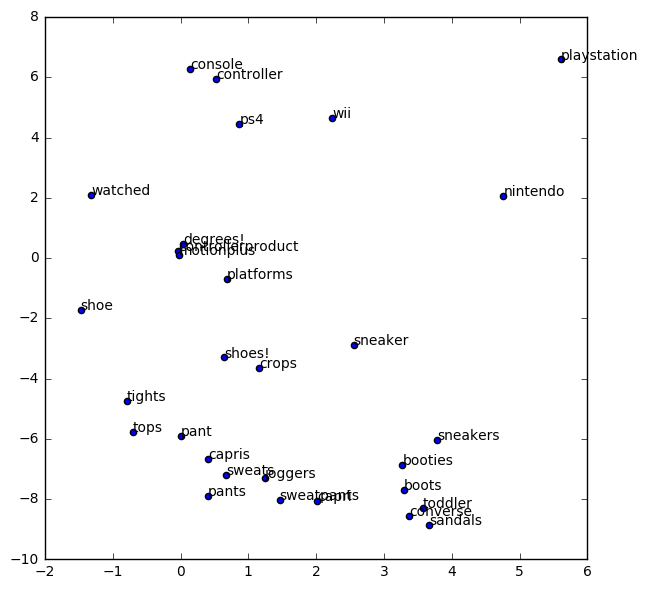

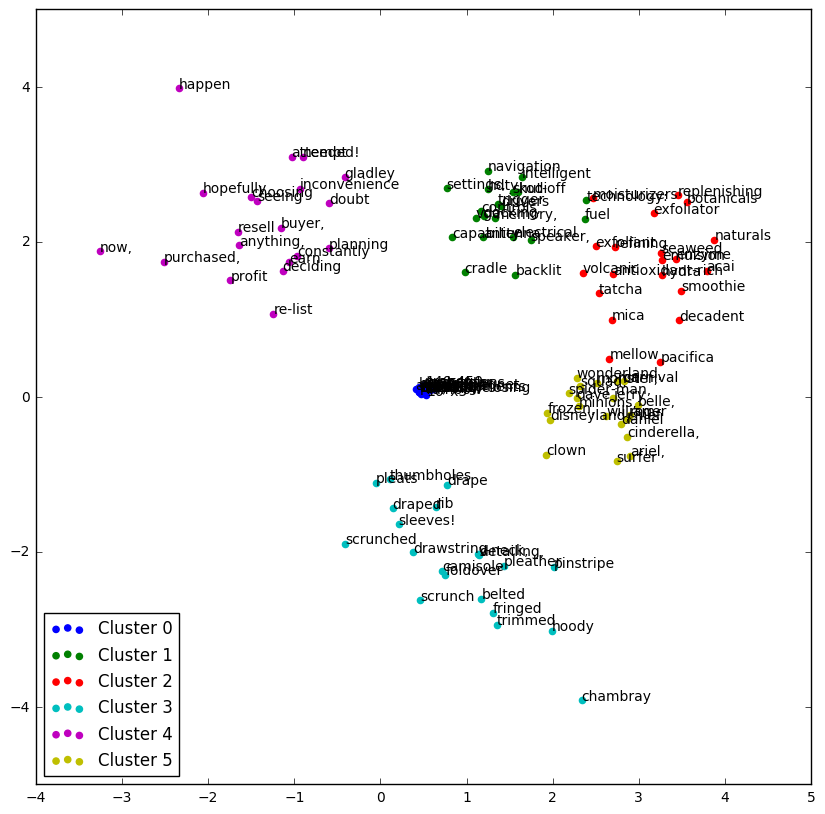

In [11]:
plt.figure(figsize=(10,10))
colors = itertools.cycle(["b","g","r","c","m","y","k","w"])
c = 0
for word_indices in centroid_embedding_nearest_words:
    clr = next(colors)
    plt.scatter(
        embeddings_2d_projection[word_indices,0],
        embeddings_2d_projection[word_indices,1],
        color=clr,
        label="Cluster " + str(c)
    )
    for ix in word_indices:
        x, y = embeddings_2d_projection[ix,:]
        plt.annotate(model.wv.index2word[ix], (x, y))
    c+=1
plt.legend(loc='lower left')
plt.show()